In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wasifalwazed","key":"21ba70521af6aa169580e3a9169fa410"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20

Dataset URL: https://www.kaggle.com/datasets/joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 98% 558M/567M [00:02<00:00, 237MB/s]
100% 567M/567M [00:02<00:00, 207MB/s]


In [ ]:
!unzip mpox-skin-lesion-dataset-version-20-msld-v20.zip

Streaming output truncated to the last 5000 lines.
  inflating: Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train/Monkeypox/MKP_58_12_6.jpg  
  inflating: Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train/Monkeypox/MKP_58_12_7.jpg  
  inflating: Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train/Monkeypox/MKP_58_12_8.jpg  
  inflating: Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train/Monkeypox/MKP_58_12_9.jpg  
  inflating: Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train/Monkeypox/MKP_58_12_ORIGINAL.jpg  
  inflating: Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train/Monkeypox/MKP_58_13_1.jpg  
  inflating: Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train/Monkeypox/MKP_58_13_10.jpg  
  inflating: Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train/Monkeypox/MKP_58_13_11.jpg  
  inflating: Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train/Monkeypox/MKP_58_13_12.jpg  
  inflating: Augmented Images/

# **Importing Necessary Libraries**

In [ ]:
import tensorflow as tf

In [ ]:

import os
import numpy as np
import pandas as pd
import random
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mimg
%matplotlib inline
from PIL import Image
from scipy import misc

import keras
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model

from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, BatchNormalization
from keras.layers import UpSampling2D, Dropout, Add, Multiply, Subtract, AveragePooling2D
from tensorflow.keras.layers import Activation, SpatialDropout2D
from tensorflow.keras.layers import Dense, Lambda
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, Permute, Flatten

from tensorflow.keras.utils import plot_model

from keras.optimizers import *
from keras.callbacks import *
from keras.activations import *

from sklearn.metrics import classification_report, confusion_matrix

# **Checking ANE Support**

In [ ]:
if tf.config.list_physical_devices('GPU'):
    print("Running on GPU")
else:
    print("Running on CPU")

Running on GPU


In [ ]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# **Train Test and Validation Location Set**

In [ ]:
train_loc = 'Augmented Images/Augmented Images/FOLDS_AUG/fold3_AUG/Train'
val_loc = 'Original Images/Original Images/FOLDS/fold3/Valid'
test_loc = 'Original Images/Original Images/FOLDS/fold3/Test'

In [ ]:
BATCH_SIZE = 16

In [ ]:
trdata = ImageDataGenerator()
train_data = trdata.flow_from_directory(directory=train_loc, target_size=(224,224),batch_size=BATCH_SIZE, shuffle=True,
                                               seed=42)

vdata = ImageDataGenerator()
val_data = vdata.flow_from_directory(directory=val_loc, target_size=(224,224),batch_size=BATCH_SIZE, shuffle=True,
                                               seed=42)

tsdata = ImageDataGenerator()
test_data = tsdata.flow_from_directory(directory=test_loc, target_size=(224,224),batch_size=BATCH_SIZE, shuffle=False, seed = 42)

Found 7532 images belonging to 6 classes.
Found 153 images belonging to 6 classes.
Found 64 images belonging to 6 classes.


In [ ]:
train_data.class_indices

{'Chickenpox': 0,
 'Cowpox': 1,
 'HFMD': 2,
 'Healthy': 3,
 'Measles': 4,
 'Monkeypox': 5}

# **MobileNet**

In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
def create_model(input_shape, n_classes , optimizer, fine_tune):

    conv_base = MobileNetV2(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.15)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
input_shape = (224, 224, 3)
opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
n_classes = 6
ft=0

# First we'll train the model without Fine-tuning
model = create_model(input_shape, n_classes, opt, ft)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## **Model Architecture**

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 263,831,414 (1006.44 MB)

 Trainable params: 263,797,302 (1006.31 MB)

 Non-trainable params: 34,112 (133.25 KB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.472127 to fit



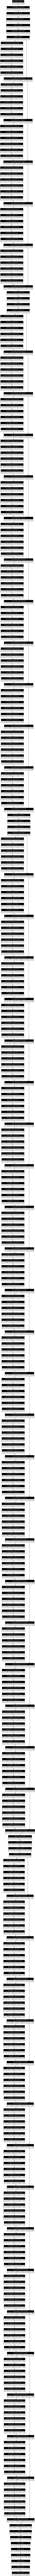

In [39]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    #show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

## **Model Training**

In [ ]:
!pip install livelossplot

In [ ]:
from livelossplot import PlotLossesKeras
from collections import Counter

In [ ]:
STEP_SIZE_TRAIN = train_data.n//train_data.batch_size
STEP_SIZE_VALID = val_data.n//test_data.batch_size
#n_epochs = 100


counter = Counter(train_data.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto')
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto', restore_best_weights=True)

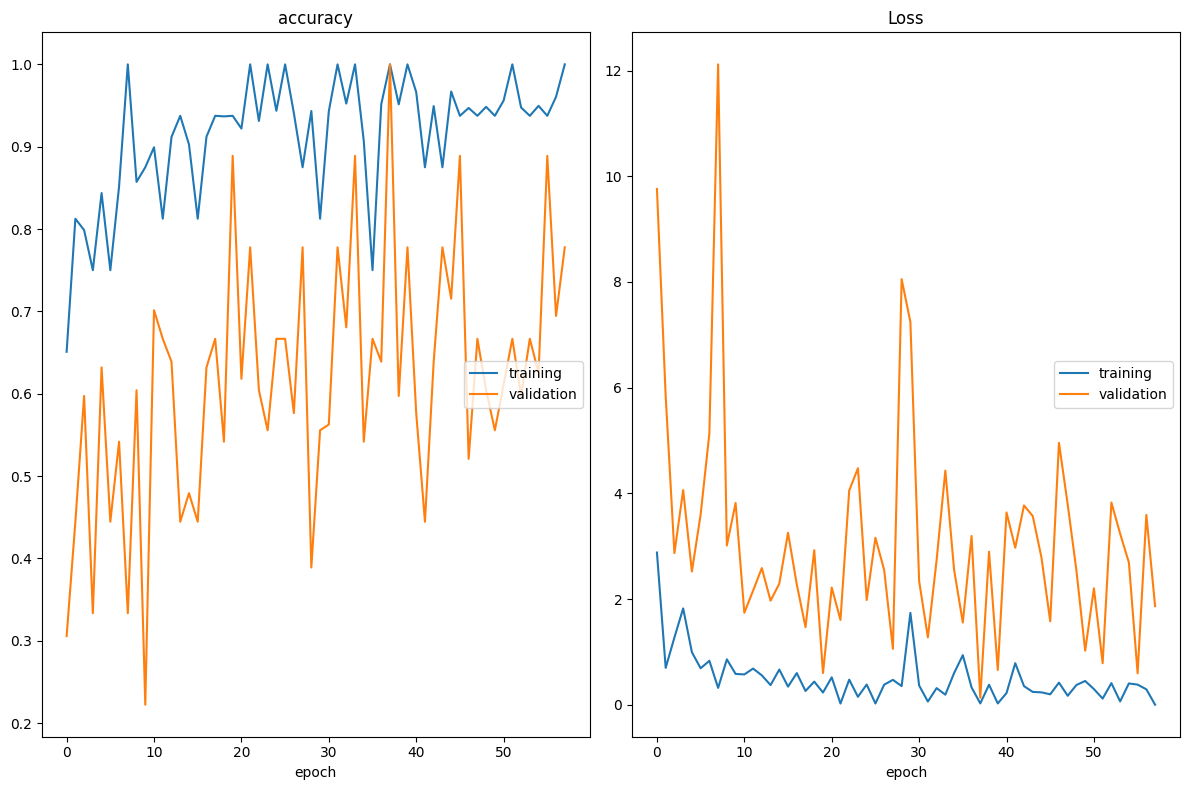

accuracy
	training         	 (min:    0.651, max:    1.000, cur:    1.000)
	validation       	 (min:    0.222, max:    1.000, cur:    0.778)
Loss
	training         	 (min:    0.001, max:    2.880, cur:    0.001)
	validation       	 (min:    0.131, max:   12.117, cur:    1.866)
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 1.0000 - loss: 7.9239e-04 - val_accuracy: 0.7778 - val_loss: 1.8663
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 38.


In [ ]:
history = model.fit(train_data,
                    epochs =100,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    class_weight = class_weights,
                    validation_data = val_data,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks=[checkpoint, early_stop, PlotLossesKeras()]
                    )

## **Model Evaluation**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
model_preds = model.predict(test_data,test_data.samples//test_data.batch_size+1)
model_pred_classes = np.argmax(model_preds , axis=1)

true_classes = test_data.classes
acc = accuracy_score(true_classes, model_pred_classes)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MobileNet-V2-based Model Accuracy: 73.44%
Precision: 0.751
Recall: 0.661
F1 Score: 0.685


In [ ]:
print('Classification Report')
target_names = ['Chickenpox','Cowpox','HFMD','Healthy','Measles','Monkeypox']
print(classification_report(test_data.classes, model_pred_classes))

Classification Report
              precision    recall  f1-score   support

           0       0.67      0.33      0.44         6
           1       1.00      0.75      0.86         4
           2       0.78      0.88      0.82        16
           3       0.86      0.55      0.67        11
           4       0.50      0.60      0.55         5
           5       0.70      0.86      0.78        22

    accuracy                           0.73        64
   macro avg       0.75      0.66      0.69        64
weighted avg       0.75      0.73      0.72        64



In [ ]:
from mlxtend.plotting import plot_confusion_matrix

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

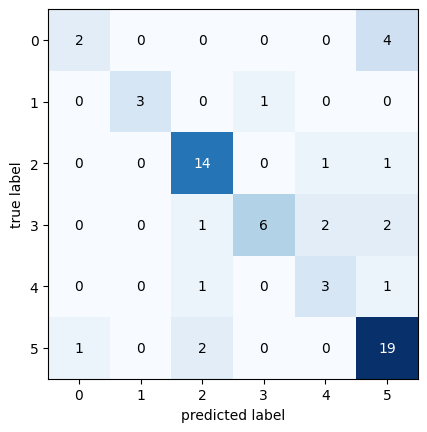

In [ ]:
x = confusion_matrix(test_data.classes, model_pred_classes)
plot_confusion_matrix(x)

# **DenseNet**

## **Model Development**

In [ ]:
from tensorflow.keras.applications import DenseNet121

In [ ]:
def create_model(input_shape, n_classes , optimizer, fine_tune):

    conv_base = DenseNet121(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.15)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
input_shape = (224, 224, 3)
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
n_classes = 6
ft=0

# First we'll train the model without Fine-tuning
model = create_model(input_shape, n_classes, opt, ft)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 217,230,710 (828.67 MB)

 Trainable params: 217,147,062 (828.35 MB)

 Non-trainable params: 83,648 (326.75 KB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.472127 to fit



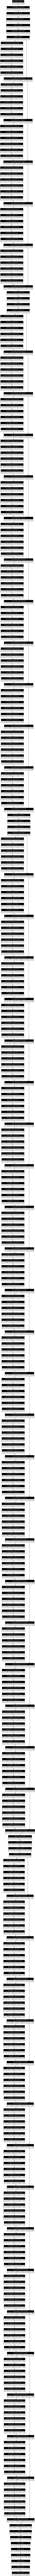

In [40]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    #show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

## **Training**

In [ ]:
from livelossplot import PlotLossesKeras
from collections import Counter

In [ ]:
STEP_SIZE_TRAIN = train_data.n//train_data.batch_size
STEP_SIZE_VALID = val_data.n//test_data.batch_size
#n_epochs = 100


counter = Counter(train_data.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto')
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto', restore_best_weights=True)

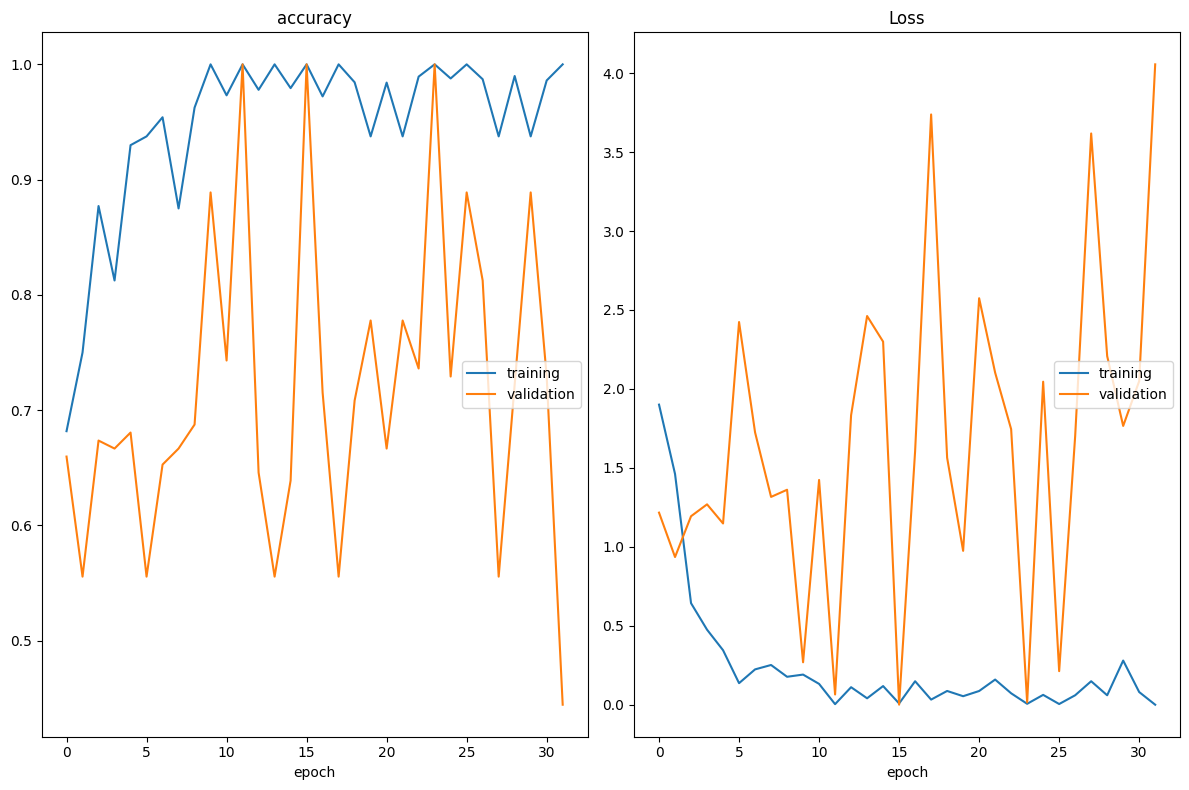

accuracy
	training         	 (min:    0.682, max:    1.000, cur:    1.000)
	validation       	 (min:    0.444, max:    1.000, cur:    0.444)
Loss
	training         	 (min:    0.000, max:    1.900, cur:    0.000)
	validation       	 (min:    0.000, max:    4.056, cur:    4.056)
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 1.0258e-04 - val_accuracy: 0.4444 - val_loss: 4.0555
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 12.


In [ ]:
history = model.fit(train_data,
                    epochs =100,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    class_weight = class_weights,
                    validation_data = val_data,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks=[checkpoint, early_stop, PlotLossesKeras()]
                    )

## **Evaluation**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
model_preds = model.predict(test_data,test_data.samples//test_data.batch_size+1)
model_pred_classes = np.argmax(model_preds , axis=1)

true_classes = test_data.classes
acc = accuracy_score(true_classes, model_pred_classes)

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step


In [ ]:
print('Classification Report')
target_names = ['Chickenpox','Cowpox','HFMD','Healthy','Measles','Monkeypox']
print(classification_report(test_data.classes, model_pred_classes))

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         6
           1       1.00      0.75      0.86         4
           2       0.88      0.88      0.88        16
           3       0.75      0.82      0.78        11
           4       0.83      1.00      0.91         5
           5       0.78      0.82      0.80        22

    accuracy                           0.80        64
   macro avg       0.79      0.77      0.77        64
weighted avg       0.79      0.80      0.79        64



In [ ]:
from mlxtend.plotting import plot_confusion_matrix

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

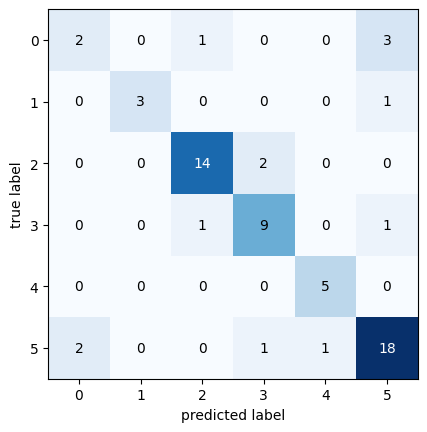

In [ ]:
x = confusion_matrix(test_data.classes, model_pred_classes)
plot_confusion_matrix(x)